
# Training an FNO on Darcy-Flow

We train a Fourier Neural Operator on our small [Darcy-Flow example](../auto_examples/plot_darcy_flow.html) .

Note that this dataset is much smaller than one we would use in practice. The small Darcy-flow is an example built to
be trained on a CPU in a few seconds, whereas normally we would train on one or multiple GPUs. 


In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

/Users/reza/Career/DMLab/SURROGATE/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Let's load the small Darcy-flow dataset. 



In [2]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


We create a simple FNO model



In [3]:
model = FNO(n_modes=(16, 16),
             in_channels=1, 
             out_channels=1,
             hidden_channels=32, 
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


## Training setup



Create the optimizer



In [4]:
optimizer = AdamW(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Then create the losses



In [5]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

## Training the model



In [6]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

Create the trainer:



In [7]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

Then train the model on our small Darcy-Flow dataset:



In [8]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=5.10, avg_loss=0.5802, train_err=18.1307
Eval: 16_h1=0.3692, 16_l2=0.2433, 32_h1=0.5608, 32_l2=0.2628
[3] time=5.30, avg_loss=0.2132, train_err=6.6619
Eval: 16_h1=0.2046, 16_l2=0.1421, 32_h1=0.4605, 32_l2=0.1782
[6] time=5.37, avg_loss=0.1942, train_err=6.0684
Eval: 16_h1=0.2041, 16_l2=0.1357, 32_h1=0.4727, 32_l2=0.1713
[9] time=5.25, avg_loss=0.1625, train_err=5.0790
Eval: 16_h1=0.2356, 16_l2=0.1681, 32_h1=0.4802, 32_l2=0.1917
[12] time=5.36, avg_loss=0.1400, train_err=4.3739
Eval: 16_h1=0.2084, 16_l2=0.1235, 32_h1=0.5088, 32_l2=0.1657
[15] time=5.47, avg_loss=0.1225, train_err=3.8289
Eval: 16_h1=0.1986, 16_l2=0.1213, 32_h1=0.4819, 32_l2=0.1596
[18] time=5.33, avg_loss=0.1160, train_err=3.6244
Eval: 16_h1=0.2031, 16_l2=0.1230, 32_h1=0.4948, 32_l2=0.1626


{'train_err': 3.2047535944730043,
 'avg_loss': 0.10255211502313615,
 'avg_lasso_loss': None,
 'epoch_train_time': 5.408101875}

Visualizing predictions
------------------------
Let's take a look at what our model's predicted outputs look like. 
Again note that in this example, we train on a very small resolution for
a very small number of epochs.
In practice, we would train at a larger resolution, on many more samples.



/var/folders/bv/7h0f0hns2y72yqgg3ww8qkkm0000gn/T/ipykernel_2052/3478568501.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


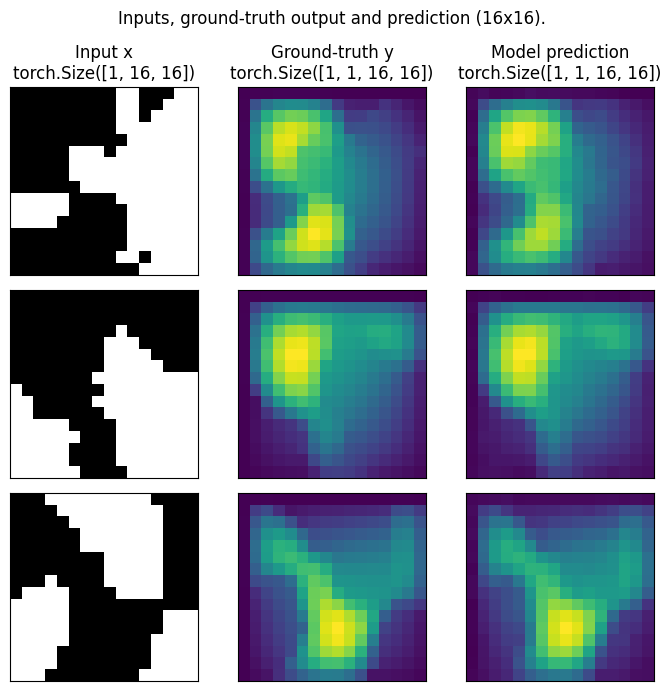

In [13]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title(f'Input x\n{x.shape}')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title(f'Ground-truth y\n{y.shape}')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title(f'Model prediction\n{out.shape}')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()

.. zero_shot :
Zero-shot super-evaluation
---------------------------
In addition to training and making predictions on the same input size, 
the FNO's invariance to the discretization of input data means we 
can natively make predictions on higher-resolution inputs and get higher-resolution outputs.



/var/folders/bv/7h0f0hns2y72yqgg3ww8qkkm0000gn/T/ipykernel_2052/4239726346.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


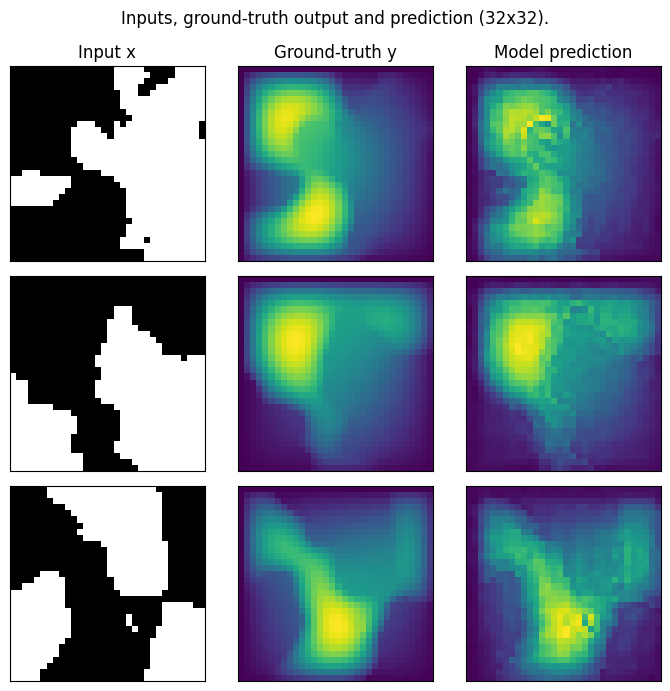

In [10]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
fig.show()

We only trained the model on data at a resolution of 16x16, and with no modifications 
or special prompting, we were able to perform inference on higher-resolution input data 
and get higher-resolution predictions! In practice, we often want to evaluate neural operators
at multiple resolutions to track a model's zero-shot super-evaluation performance throughout 
training. That's why many of our datasets, including the small Darcy-flow we showcased,
are parameterized with a list of `test_resolutions` to choose from. 

However, as you can see, these predictions are noisier than we would expect for a model evaluated 
at the same resolution at which it was trained. Leveraging the FNO's discretization-invariance, there
are other ways to scale the outputs of the FNO to train a true super-resolution capability. 
